In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
#
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

In [2]:
filepath=r'E:\ai\Downloads\Data'

In [3]:
painting = pd.read_csv(os.path.join(filepath,'painting.csv'))
painting.head()

,file,title,artist,genre,style
0,Realism/vincent-van-gogh_pine-trees-in-the-fen...,pine-trees-in-the-fen-1884,vincent-van-gogh,landscape,Realism
1,Baroque/rembrandt_the-angel-appearing-to-the-s...,the-angel-appearing-to-the-shepherds-1634,rembrandt,religious painting,Baroque
2,Post_Impressionism/paul-cezanne_portrait-of-th...,portrait-of-the-artist-s-son,paul-cezanne,portrait,Post_Impressionism
3,Impressionism/pierre-auguste-renoir_young-girl...,young-girl-seated-in-a-meadow-1916,pierre-auguste-renoir,genre painting,Impressionism
4,Romanticism/ivan-aivazovsky_morning-1851.jpg,morning-1851,ivan-aivazovsky,marina,Romanticism


In [4]:
painting_lst = np.load(os.path.join(filepath,'data.npy'))
painting_lst.shape

(80158, 128, 128, 3)

In [5]:
# 1. X, y 데이터 준비 (painting_lst와 painting['style'])
X = painting_lst  # (80158, height, width, channels) 형태
y = painting['style']  # 스타일 정보 (문자형 라벨)

In [6]:
# 2. 문자열 라벨을 숫자 라벨로 변환
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # 문자열 라벨을 숫자로 변환

# 3. 숫자 라벨을 원-핫 인코딩
y_one_hot = to_categorical(y_encoded, num_classes=len(label_encoder.classes_))

In [7]:
# 4. 이미지를 1차원 배열로 변환 (모든 이미지를 1차원 벡터로 변경)
# X_flattened = X.reshape(X.shape[0], -1)  # X는 (80158, height, width, channels), 이걸 (80158, height*width*channels)로 바꿈

# 5. 훈련용과 테스트용 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((64126, 128, 128, 3), (16032, 128, 128, 3), (64126, 27), (16032, 27))

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# 6. CNN 모델 정의
model = tf.keras.Sequential([
    # 첫 번째 합성곱 레이어 (Conv2D)
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),  # 이미지 크기와 채널 수에 맞게 설정
    MaxPooling2D(pool_size=(2, 2)),  # 풀링 레이어로 특징 맵의 크기 줄이기
    
    # 두 번째 합성곱 레이어
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # 세 번째 합성곱 레이어
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # 평탄화 레이어 (Dense 레이어를 사용하기 위해)
    Flatten(),
    
    # 완전 연결 레이어 (Fully Connected)
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),  # 과적합 방지를 위한 드롭아웃
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    
    # 출력 레이어 (Softmax)
    Dense(len(y_train[0]), activation='softmax')  # 클래스 수에 맞게 출력 유닛 설정
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [9]:
# 7. 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# 8. 모델 학습
early_stopping = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
hist=model.fit(
    X_train, y_train,
    epochs=300,  # 에포크 수 설정
    batch_size=32,  # 배치 크기 설정
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/300
2004/2004 [==============================] - 39s 17ms/step - loss: 2.7072 - accuracy: 0.1813 - val_loss: 2.7648 - val_accuracy: 0.2156
Epoch 2/300
2004/2004 [==============================] - 33s 16ms/step - loss: 2.5727 - accuracy: 0.2061 - val_loss: 2.5289 - val_accuracy: 0.2431
Epoch 3/300
2004/2004 [==============================] - 33s 17ms/step - loss: 2.4524 - accuracy: 0.2370 - val_loss: 6.8421 - val_accuracy: 0.1637
Epoch 4/300
2004/2004 [==============================] - 33s 16ms/step - loss: 2.4462 - accuracy: 0.2382 - val_loss: 2.3790 - val_accuracy: 0.2705
Epoch 5/300
2004/2004 [==============================] - 33s 16ms/step - loss: 2.5112 - accuracy: 0.2239 - val_loss: 3.7773 - val_accuracy: 0.2413
Epoch 6/300
2004/2004 [==============================] - 33s 16ms/step - loss: 2.4343 - accuracy: 0.2410 - val_loss: 7.2610 - val_accuracy: 0.0308
Epoch 7/300
2004/2004 [==============================] - 33s 16ms/step - loss: 2.3904 - accuracy: 0.2511 - val_loss: 2

2004/2004 [==============================] - 33s 16ms/step - loss: 1.3474 - accuracy: 0.5641 - val_loss: 4.1982 - val_accuracy: 0.3379
Epoch 57/300
2004/2004 [==============================] - 33s 16ms/step - loss: 1.2245 - accuracy: 0.5999 - val_loss: 3.9222 - val_accuracy: 0.3233
Epoch 58/300
2004/2004 [==============================] - 33s 16ms/step - loss: 1.1936 - accuracy: 0.6126 - val_loss: 2.9795 - val_accuracy: 0.3244
Epoch 59/300
2004/2004 [==============================] - 33s 16ms/step - loss: 1.1713 - accuracy: 0.6194 - val_loss: 2.6434 - val_accuracy: 0.3283
Epoch 60/300
2004/2004 [==============================] - 33s 16ms/step - loss: 1.1436 - accuracy: 0.6275 - val_loss: 2.9590 - val_accuracy: 0.3343
Epoch 61/300
2004/2004 [==============================] - 33s 17ms/step - loss: 1.1220 - accuracy: 0.6346 - val_loss: 4.2338 - val_accuracy: 0.3255
Epoch 62/300
2004/2004 [==============================] - 33s 17ms/step - loss: 1.0839 - accuracy: 0.6470 - val_loss: 6.6177 

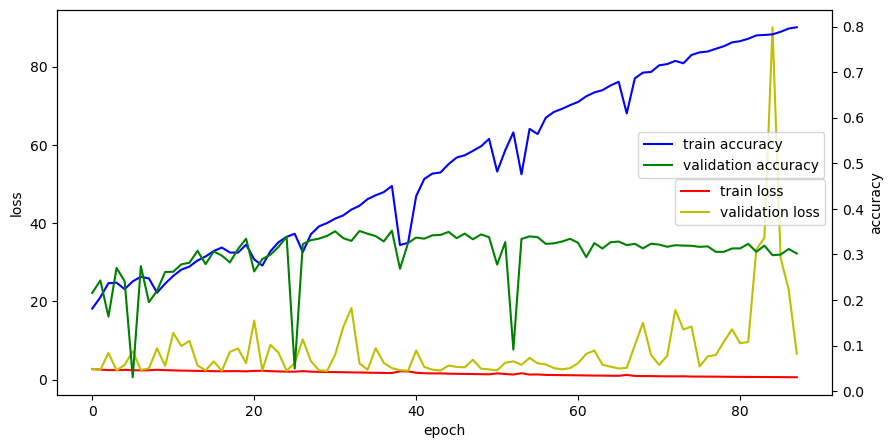

In [11]:
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

In [12]:
# 9. 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print('accuracy : {:.2f}'.format(accuracy*100))

501/501 [==============================] - 2s 5ms/step - loss: 2.9617 - accuracy: 0.3522
accuracy : 35.22


In [13]:
# 예측치와 실제값을 이용한 교차표
yhat = model.predict(X_test).argmax(axis=1)  # 예측치
# yhat = np.argmax(model.predict(X_test), axis=1)
# display(pd.crosstab(y_test, yhat))  # 실제값, 예측치 : 결과 - 데이터프레임
# print(confusion_matrix(y_test, yhat))  # 결과 - 넘파이배열

cnt = 0
for y, h in zip(y_test, yhat):
    if y != h:
        cnt += 1
print('예측이 틀린 갯수 : ', cnt)

501/501 [==============================] - 2s 4ms/step


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()